# Import Modules and files

In [1]:
# Critical imports

import pandas as pd
import numpy as np
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from  datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore')

import lightgbm as lgb
from sklearn import preprocessing, metrics
from sklearn.model_selection import StratifiedShuffleSplit
import gc
import os



In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [19]:
%cd /content/drive/My Drive/projects/m5-forecasting

/content/drive/My Drive/projects/m5-forecasting


In [92]:
df_cal = pd.read_csv('/content/drive/My Drive/projects/m5-forecasting/calendar.csv')
df_new_cal = pd.read_csv('/content/drive/My Drive/projects/m5-forecasting/calender_new.csv')
#df_train_sales_valid = pd.read_csv('/content/drive/My Drive/projects/m5-forecasting/sales_train_validation.csv')
df_train_sales = pd.read_csv('/content/drive/My Drive/projects/m5-forecasting/sales_train_evaluation.csv')
df_prices = pd.read_csv('/content/drive/My Drive/projects/m5-forecasting/sell_prices.csv')
#df_submission = pd.read_csv('/content/drive/My Drive/projects/m5-forecasting/sample_submission.csv')

In [39]:
df_train_sales

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,...,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,1,3,0,1,1,1,3,0,1,1,0,0,0,2,0,3,5,0,0,1,1,0,2,1,2,2,1,0,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,2,2,1,2,1,1,1,0,1,1,1,0,0,1,1,0,2,1,0,0,0,0,2,1,3,0,0,1,0,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3,0,1,0,5,4,1,0,1,3,7,2,0,0,1,2,4,1,6,4,0,0,0,2,2,4,2,1,1,1,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,2,1,1,0,1,1,2,2,2,4,1,0,2,3,1,0,3,2,3,1,1,3,2,3,2,2,2,2,0,0,0,2,1,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,0,3,1,4,1,0,0,3,4,4,0,0,1,0,1,1,7,7,3,6,3,3,7,12,4,2,7,5,12,5,...,0,0,2,0,0,0,0,0,1,0,0,1,0,0,0,2,2,0,0,0,2,0,0,1,1,1,0,0,1,0,1,0,3,0,1,1,0,0,1,1
30486,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,0,5,0,1,1,3,1,1,0,4,2,0,1,2,1,1,0,0,0,0,3,1,1,1,2,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
30487,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,2,4,1,8,5,2,7,5,3,5,20,8,10,3,3,4,7,2,3,5,6,3,4,1,2,5,1,2,2,2,...,0,0,2,1,0,2,0,1,0,0,1,0,0,0,1,1,0,2,1,1,0,0,1,0,0,1,0,3,3,1,0,0,1,2,0,1,0,1,0,2
30488,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,3,0,0,1,0,0,1,0,3,1,3,1,3,0,1,2,1,0,2,1,1,2,0,2,1,1,0,2,1,1,1,1,4,6,0,1,1,1,0


In [40]:
numcols = [f"d_{day}" for day in range(1942,2042)]
df_train_sales_new = pd.concat([df_train_sales,pd.DataFrame(columns=numcols)])
#del df_train_sales
df_train_sales_new

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,...,d_2002,d_2003,d_2004,d_2005,d_2006,d_2007,d_2008,d_2009,d_2010,d_2011,d_2012,d_2013,d_2014,d_2015,d_2016,d_2017,d_2018,d_2019,d_2020,d_2021,d_2022,d_2023,d_2024,d_2025,d_2026,d_2027,d_2028,d_2029,d_2030,d_2031,d_2032,d_2033,d_2034,d_2035,d_2036,d_2037,d_2038,d_2039,d_2040,d_2041
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0.0,0.0,2.0,2.0,0.0,3.0,1.0,4.0,1.0,0.0,0.0,3.0,4.0,4.0,0.0,0.0,1.0,0.0,1.0,1.0,7.0,7.0,3.0,6.0,3.0,3.0,7.0,12.0,4.0,2.0,7.0,5.0,12.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30486,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0.0,0.0,0.0,0.0,0.0,5.0,0.0,1.0,1.0,3.0,1.0,1.0,0.0,4.0,2.0,0.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,1.0,2.0,0.0,1.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30487,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0.0,6.0,0.0,2.0,2.0,4.0,1.0,8.0,5.0,2.0,7.0,5.0,3.0,5.0,20.0,8.0,10.0,3.0,3.0,4.0,7.0,2.0,3.0,5.0,6.0,3.0,4.0,1.0,2.0,5.0,1.0,2.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30488,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,Na

In [93]:
df_new_cal = df_new_cal.drop(columns=['Unnamed: 0'])
df_new_cal = df_new_cal[:-1]
df_new_cal

,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,week,quarter,mday,d
0,2011-01-29,11101.0,Saturday,5,1,2011,NaN,NaN,NaN,NaN,0.0,0.0,0.0,4,1,29,d_1
1,2011-01-30,11101.0,Sunday,6,1,2011,NaN,NaN,NaN,NaN,0.0,0.0,0.0,4,1,30,d_2
2,2011-01-31,11101.0,Monday,0,1,2011,NaN,NaN,NaN,NaN,0.0,0.0,0.0,5,1,31,d_3
3,2011-02-01,11101.0,Tuesday,1,2,2011,NaN,NaN,NaN,NaN,1.0,1.0,0.0,5,1,1,d_4
4,2011-02-02,11101.0,Wednesday,2,2,2011,NaN,NaN,NaN,NaN,1.0,0.0,1.0,5,1,2,d_5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2036,2016-08-26,NaN,Friday,4,8,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34,3,26,d_2037
2037,2016-08-27,NaN,Saturday,5,8,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34,3,27,d_2038
2038,2016-08-28,NaN,Sunday,6,8,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34,3,28,d_2039
2039,2016-08-29,NaN,Monday,0,8,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35,3,29,d_2040


# Create dataset and features

In [6]:
states = ['CA','TX','WI']
products = ['FOODS','HOBBIES','HOUSEHOLD']

df_foods_ca, df_foods_tx ,df_foods_wi, df_hobbies_ca, df_hobbies_tx, df_hobbies_wi, df_hh_ca, df_hh_tx, df_hh_wi = (df_train_sales_new[(df_train_sales_new['cat_id'] == p)&(df_train_sales_new['state_id']==s)] for p in products for s in states)

In [7]:
#helper functions

def create_data(df):
    df_melt = pd.melt(df, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'd', value_name = 'demand')
    df_melt = reduce_mem_usage(df_melt)
    
    
    df_melt = pd.merge(df_melt, df_new_cal, how = 'left', left_on = ['d'], right_on = ['d'])
    df_melt = reduce_mem_usage(df_melt)

    #d_1 to d_1913
    data = df_melt.merge(
        df_prices, on=["store_id", "item_id", "wm_yr_wk"], how='left')
    data = reduce_mem_usage(data)

    nan_features = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
    for feature in nan_features:
        data[feature].fillna('unknown', inplace = True)

    col = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id',
        'event_name_1', 'event_name_2', 'event_type_1', 'event_type_2']
    encoder = preprocessing.LabelEncoder()
    for c in col:
        data[c] = encoder.fit_transform(data[c])

    data = reduce_mem_usage(data)
    
    data['is_weekend'] = (data['wday'] <= 2).astype(int)
    
    
    #create date-time features columns
    date_features = {
        "wday": "weekday",
        "week": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",
    }


    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in data.columns:
          data[date_feat_name] = data[date_feat_name].astype("int16")
        else:
          data['date'] = pd.to_datetime(data["date"])
          data[date_feat_name] = getattr(
              data["date"].dt, date_feat_func).astype("int16")

    data = reduce_mem_usage(data)
    return data 

In [8]:
def create_features(df):
    dayLags = [7, 28]
    lagSalesCols = [f"lag_{dayLag}" for dayLag in dayLags]
    for dayLag, lagSalesCol in zip(dayLags, lagSalesCols):
        df[lagSalesCol] = df[["id", "demand"]].groupby("id")[
            "demand"].shift(dayLag)

    reduce_mem_usage(df)

    windows = [7, 14, 28]
    for window in windows:
        for dayLag, lagSalesCol in zip(dayLags, lagSalesCols):
            df[f"rmean_{dayLag}_{window}"] = df[["id", lagSalesCol]].groupby(
                "id")[lagSalesCol].transform(lambda x: x.rolling(window).mean())

    return df

In [9]:
%time
#creating data
print('Preparing training data')
data_train = create_data(df_hh_tx)

values = {'snap_CA': 0, 'snap_TX': 0, 'snap_WI': 0}
data_train = reduce_mem_usage(data_train)
data_train = data_train.fillna(value = values)
data_train

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.63 µs
Preparing training data
Mem. usage decreased to 391.28 Mb (0.0% reduction)
Mem. usage decreased to 825.36 Mb (32.5% reduction)
Mem. usage decreased to 837.59 Mb (4.2% reduction)
Mem. usage decreased to 458.53 Mb (45.3% reduction)
Mem. usage decreased to 464.65 Mb (13.6% reduction)
Mem. usage decreased to 464.65 Mb (0.0% reduction)


,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,week,quarter,mday,sell_price,is_weekend
0,HOUSEHOLD_1_001_TX_1_evaluation,0,0,0,0,0,d_1,0,2011-01-29,11104.0,Saturday,5,1,2011,30,4,4,2,0.0,0.0,0.0,4,1,29,6.320312,0
1,HOUSEHOLD_1_002_TX_1_evaluation,1,0,0,0,0,d_1,0,2011-01-29,11104.0,Saturday,5,1,2011,30,4,4,2,0.0,0.0,0.0,4,1,29,6.320312,0
2,HOUSEHOLD_1_003_TX_1_evaluation,2,0,0,0,0,d_1,0,2011-01-29,11104.0,Saturday,5,1,2011,30,4,4,2,0.0,0.0,0.0,4,1,29,NaN,0
3,HOUSEHOLD_1_004_TX_1_evaluation,3,0,0,0,0,d_1,4,2011-01-29,11104.0,Saturday,5,1,2011,30,4,4,2,0.0,0.0,0.0,4,1,29,1.980469,0
4,HOUSEHOLD_1_005_TX_1_evaluation,4,0,0,0,0,d_1,2,2011-01-29,11104.0,Saturday,5,1,2011,30,4,4,2,0.0,0.0,0.0,4,1,29,10.718750,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6410776,HOUSEHOLD_2_512_TX_3_evaluation,1042,1,0,2,0,d_2041,NaN,2016-08-30,NaN,Tuesday,1,8,2016,30,4,4,2,0.0,0.0,0.0,35,3,30,NaN,1
6410777,HOUSEHOLD_2_513_TX_3_evaluation,1043,1,0,2,0,d_2041,NaN,2016-08-30,NaN,Tuesday,1,8,2016,30,4,4,2,0.0,0.0,0.0,35,3,30,NaN,1
6410778,HOUSEHOLD_2_514_TX_3_evaluation,1044,1,0,2,0,d_2041,NaN,2016-08-30,NaN,Tuesday,1,8,2016,30,4,4,2,0.0,0.0,0.0,35,3,30,NaN,1
6410779,HOUSEHOLD_2_515_TX_3_evaluation,1045,1,0,2,0,d_2041,NaN,2016-08-30,NaN,Tuesday,1,8,2016,30,4,4,2,0.0,0.0,0.0,35,3,30,NaN,1


In [10]:
%%time

#creating features
reduce_mem_usage(data_train)
print('Creating lag and roll mean for training data')
train_data = create_features(data_train)
reduce_mem_usage(train_data)
%time

Mem. usage decreased to 464.65 Mb (0.0% reduction)
Creating lag and roll mean for training data
Mem. usage decreased to 562.47 Mb (0.0% reduction)
Mem. usage decreased to 635.83 Mb (25.7% reduction)
CPU times: user 0 ns, sys: 3 µs, total: 3 µs
Wall time: 5.96 µs
CPU times: user 59.6 s, sys: 280 ms, total: 59.8 s
Wall time: 1min 3s


In [11]:
train_data = data_train
train_data[['demand', 'lag_7', 'lag_28']] = train_data[['demand', 'lag_7', 'lag_28']].astype('float16')
train_data['date'] = pd.to_datetime(train_data["date"])
train_data

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,week,quarter,mday,sell_price,is_weekend,lag_7,lag_28,rmean_7_7,rmean_28_7,rmean_7_14,rmean_28_14,rmean_7_28,rmean_28_28
0,HOUSEHOLD_1_001_TX_1_evaluation,0,0,0,0,0,d_1,0.0,2011-01-29,11104.0,Saturday,5,1,2011,30,4,4,2,0.0,0.0,0.0,4,1,29,6.320312,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,HOUSEHOLD_1_002_TX_1_evaluation,1,0,0,0,0,d_1,0.0,2011-01-29,11104.0,Saturday,5,1,2011,30,4,4,2,0.0,0.0,0.0,4,1,29,6.320312,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,HOUSEHOLD_1_003_TX_1_evaluation,2,0,0,0,0,d_1,0.0,2011-01-29,11104.0,Saturday,5,1,2011,30,4,4,2,0.0,0.0,0.0,4,1,29,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HOUSEHOLD_1_004_TX_1_evaluation,3,0,0,0,0,d_1,4.0,2011-01-29,11104.0,Saturday,5,1,2011,30,4,4,2,0.0,0.0,0.0,4,1,29,1.980469,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HOUSEHOLD_1_005_TX_1_evaluation,4,0,0,0,0,d_1,2.0,2011-01-29,11104.0,Saturday,5,1,2011,30,4,4,2,0.0,0.0,0.0,4,1,29,10.718750,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6410776,HOUSEHOLD_2_512_TX_3_evaluation,1042,1,0,2,0,d_2041,NaN,2016-08-30,NaN,Tuesday,1,8,2016,30,4,4,2,0.0,0.0,0.0,35,3,30,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6410777,HOUSEHOLD_2_513_TX_3_evaluation,1043,1,0,2,0,d_2041,NaN,2016-08-30,NaN,Tuesday,1,8,2016,30,4,4,2,0.0,0.0,0.0,35,3,30,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6410778,HOUSEHOLD_2_514_TX_3_evaluation,1044,1,0,2,0,d_2041,NaN,2016-08-30,NaN,Tuesday,1,8,2016,30,4,4,2,0.0,0.0,0.0,35,3,30,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6410779,HOUSEHOLD_2_515_TX_3_evaluation,1045,1,0,2,0,d_2041,NaN,2016-08-30,NaN,Tuesday,1,8,2016,30,4,4,2,0.0,0.0,0.0,35,3,30,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
train_data.dtypes

id                      object
item_id                  int16
dept_id                   int8
cat_id                    int8
store_id                  int8
state_id                  int8
d                       object
demand                 float16
date            datetime64[ns]
wm_yr_wk               float16
weekday                 object
wday                      int8
month                     int8
year                     int16
event_name_1              int8
event_type_1              int8
event_name_2              int8
event_type_2              int8
snap_CA                float16
snap_TX                float16
snap_WI                float16
week                      int8
quarter                   int8
mday                      int8
sell_price             float16
is_weekend                int8
lag_7                  float16
lag_28                 float16
rmean_7_7              float16
rmean_28_7             float16
rmean_7_14             float16
rmean_28_14            float16
rmean_7_

# Training and Validation dataset formation

Create a master data table


*   Training data: 2014-04-24 to 2016-04-23 (d1 - d1913)
*   Validation data: 2016-04-23 to 2016-05-22 (d1914 - d1941)
* Test data: 2016-05-23 to 2016-06-19 (d1942 - d1969)
* Forecasting data: 2016-06-19 to 2016-09-30 (d1970 - d2041)



In [13]:
cat_features = ['item_id', 'store_id', 'cat_id', 'dept_id', 'state_id', 
                'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
               

useless_cols = ["id", "date", "demand", "d", "wm_yr_wk", "weekday"]

train_cols = train_data.columns[~ train_data.columns.isin(useless_cols)]  # columns for training.
label_col = ['demand']

train_start_date = '2014-04-23'
train_end_date = '2016-04-22'
valid_start_date = '2016-04-23'
valid_end_date = '2016-05-22'


train_dates = (train_data['date'] > train_start_date) & (train_data['date'] <= train_end_date)
df_train = train_data.loc[train_dates]
x_train = df_train[train_cols]
y_train = df_train['demand']

valid_dates = (train_data['date']>= valid_start_date) & (train_data['date'] <= valid_end_date)
df_valid = train_data.loc[valid_dates]
x_valid = df_valid[train_cols]
y_valid = df_valid['demand']


In [14]:
%time

train_set = lgb.Dataset(x_train, y_train, categorical_feature = cat_features, free_raw_data=False)
val_set = lgb.Dataset(x_valid, y_valid, categorical_feature = cat_features,free_raw_data=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


In [15]:
params = {
          'boosting_type': 'gbdt',
          'objective': 'poisson',
          'tweedie_variance_power': 1.1,
          'metric': 'rmse',
          'subsample': 0.5,
          'subsample_freq': 1,
          'learning_rate': 0.01,
          'num_leaves': 2**11-1,
          'min_data_in_leaf': 2**12-1,
          'feature_fraction': 0.5,
          'max_bin': 100,
          'n_estimators': 1400,
          'boost_from_average': False,
          'verbose': -1,
      } 

In [16]:
%%time

m_lgb = lgb.train(params, train_set, num_boost_round = 1500 , early_stopping_rounds = 50, valid_sets = [val_set], verbose_eval = 50)

Training until validation scores don't improve for 50 rounds.
[50]	valid_0's rmse: 1.79944
[100]	valid_0's rmse: 1.64235
[150]	valid_0's rmse: 1.53524
[200]	valid_0's rmse: 1.46365
[250]	valid_0's rmse: 1.41577
[300]	valid_0's rmse: 1.38444
[350]	valid_0's rmse: 1.36322
[400]	valid_0's rmse: 1.34937
[450]	valid_0's rmse: 1.34013
[500]	valid_0's rmse: 1.33342
[550]	valid_0's rmse: 1.32891
[600]	valid_0's rmse: 1.32553
[650]	valid_0's rmse: 1.32318
[700]	valid_0's rmse: 1.32156
[750]	valid_0's rmse: 1.3203
[800]	valid_0's rmse: 1.31919
[850]	valid_0's rmse: 1.31838
[900]	valid_0's rmse: 1.31782
[950]	valid_0's rmse: 1.31728
[1000]	valid_0's rmse: 1.31691
[1050]	valid_0's rmse: 1.31659
[1100]	valid_0's rmse: 1.31641
[1150]	valid_0's rmse: 1.31614
[1200]	valid_0's rmse: 1.31595
[1250]	valid_0's rmse: 1.31577
[1300]	valid_0's rmse: 1.31556
[1350]	valid_0's rmse: 1.31534
[1400]	valid_0's rmse: 1.3151
Did not meet early stopping. Best iteration is:
[1400]	valid_0's rmse: 1.3151
CPU times: use

In [20]:
%pwd

'/content/drive/My Drive/projects/m5-forecasting'

In [21]:
m_lgb.save_model("hh_tx_model_poisson.lgb")

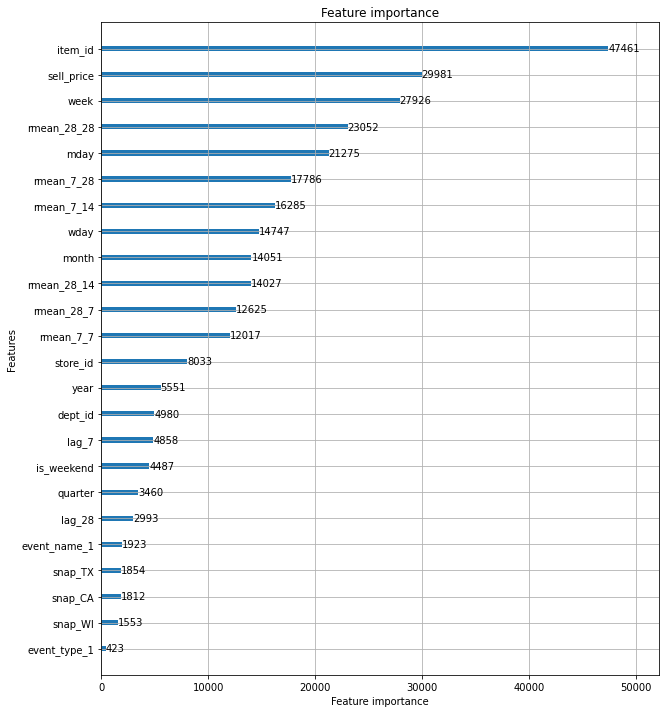

In [22]:
lgb.plot_importance(m_lgb, figsize=(10, 12))

# Evaluation

In [119]:

m_lgb = lgb.Booster(model_file='foods_ca_model_poisson.lgb')

In [120]:
start_date = '2016-02-14'
end_date = '2016-05-22'
test_start_date = '2016-05-23'
test_end_date = '2016-06-19'
forecast_start_date = '2016-06-20'
forecast_end_date = '2016-08-30'

In [121]:
needed_col = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'demand', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'week', 'quarter', 'mday',
       'sell_price', 'is_weekend']

In [123]:
train_data

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,week,quarter,mday,sell_price,is_weekend,lag_7,lag_28,rmean_7_7,rmean_28_7,rmean_7_14,rmean_28_14,rmean_7_28,rmean_28_28
0,HOUSEHOLD_1_001_TX_1_evaluation,0,0,0,0,0,d_1,0.0,2011-01-29,11104.0,Saturday,5,1,2011,30,4,4,2,0.0,0.0,0.0,4,1,29,6.320312,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,HOUSEHOLD_1_002_TX_1_evaluation,1,0,0,0,0,d_1,0.0,2011-01-29,11104.0,Saturday,5,1,2011,30,4,4,2,0.0,0.0,0.0,4,1,29,6.320312,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,HOUSEHOLD_1_003_TX_1_evaluation,2,0,0,0,0,d_1,0.0,2011-01-29,11104.0,Saturday,5,1,2011,30,4,4,2,0.0,0.0,0.0,4,1,29,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HOUSEHOLD_1_004_TX_1_evaluation,3,0,0,0,0,d_1,4.0,2011-01-29,11104.0,Saturday,5,1,2011,30,4,4,2,0.0,0.0,0.0,4,1,29,1.980469,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HOUSEHOLD_1_005_TX_1_evaluation,4,0,0,0,0,d_1,2.0,2011-01-29,11104.0,Saturday,5,1,2011,30,4,4,2,0.0,0.0,0.0,4,1,29,10.718750,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6410776,HOUSEHOLD_2_512_TX_3_evaluation,1042,1,0,2,0,d_2041,NaN,2016-08-30,NaN,Tuesday,1,8,2016,30,4,4,2,0.0,0.0,0.0,35,3,30,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6410777,HOUSEHOLD_2_513_TX_3_evaluation,1043,1,0,2,0,d_2041,NaN,2016-08-30,NaN,Tuesday,1,8,2016,30,4,4,2,0.0,0.0,0.0,35,3,30,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6410778,HOUSEHOLD_2_514_TX_3_evaluation,1044,1,0,2,0,d_2041,NaN,2016-08-30,NaN,Tuesday,1,8,2016,30,4,4,2,0.0,0.0,0.0,35,3,30,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6410779,HOUSEHOLD_2_515_TX_3_evaluation,1045,1,0,2,0,d_2041,NaN,2016-08-30,NaN,Tuesday,1,8,2016,30,4,4,2,0.0,0.0,0.0,35,3,30,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [122]:
previous_dates_forecast = (train_data['date'] >= start_date) & (train_data['date'] <= forecast_end_date)
forecast_previous_data = train_data.loc[previous_dates_forecast]
forecast_previous_data = forecast_previous_data[needed_col]
#y_test = testing_data['demand']
forecast_previous_data

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,week,quarter,mday,sell_price,is_weekend
5785722,HOUSEHOLD_1_001_TX_1_evaluation,0,0,0,0,0,d_1843,0.0,2016-02-14,11600.0,Sunday,6,2,2016,28,0,4,2,0.0,0.0,1.0,6,1,14,NaN,0
5785723,HOUSEHOLD_1_002_TX_1_evaluation,1,0,0,0,0,d_1843,0.0,2016-02-14,11600.0,Sunday,6,2,2016,28,0,4,2,0.0,0.0,1.0,6,1,14,NaN,0
5785724,HOUSEHOLD_1_003_TX_1_evaluation,2,0,0,0,0,d_1843,0.0,2016-02-14,11600.0,Sunday,6,2,2016,28,0,4,2,0.0,0.0,1.0,6,1,14,NaN,0
5785725,HOUSEHOLD_1_004_TX_1_evaluation,3,0,0,0,0,d_1843,1.0,2016-02-14,11600.0,Sunday,6,2,2016,28,0,4,2,0.0,0.0,1.0,6,1,14,NaN,0
5785726,HOUSEHOLD_1_005_TX_1_evaluation,4,0,0,0,0,d_1843,0.0,2016-02-14,11600.0,Sunday,6,2,2016,28,0,4,2,0.0,0.0,1.0,6,1,14,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6410776,HOUSEHOLD_2_512_TX_3_evaluation,1042,1,0,2,0,d_2041,NaN,2016-08-30,NaN,Tuesday,1,8,2016,30,4,4,2,0.0,0.0,0.0,35,3,30,NaN,1
6410777,HOUSEHOLD_2_513_TX_3_evaluation,1043,1,0,2,0,d_2041,NaN,2016-08-30,NaN,Tuesday,1,8,2016,30,4,4,2,0.0,0.0,0.0,35,3,30,NaN,1
6410778,HOUSEHOLD_2_514_TX_3_evaluation,1044,1,0,2,0,d_2041,NaN,2016-08-30,NaN,Tuesday,1,8,2016,30,4,4,2,0.0,0.0,0.0,35,3,30,NaN,1
6410779,HOUSEHOLD_2_515_TX_3_evaluation,1045,1,0,2,0,d_2041,NaN,2016-08-30,NaN,Tuesday,1,8,2016,30,4,4,2,0.0,0.0,0.0,35,3,30,NaN,1


In [26]:
alpha = 1.25
max_lags = 70
cols = [f"F{i}" for i in range(1,29)]

df_test = forecast_previous_data.copy()

fday = datetime(2016, 5, 23)

for tdelta in range(0, 100):
    day = fday + timedelta(days=tdelta)
    print('Predicting for:', day)
    test_data = df_test[(df_test.date >= day - timedelta(days=max_lags)) & (df_test.date <= day)].copy()
    create_features(test_data)
    test_data = test_data.loc[test_data.date == day , train_cols]
    df_test.loc[df_test.date == day, "demand"] = alpha*m_lgb.predict(test_data)

Predicting for: 2016-05-23 00:00:00
Mem. usage decreased to 15.74 Mb (0.0% reduction)
Predicting for: 2016-05-24 00:00:00
Mem. usage decreased to 15.74 Mb (0.0% reduction)
Predicting for: 2016-05-25 00:00:00
Mem. usage decreased to 15.74 Mb (0.0% reduction)
Predicting for: 2016-05-26 00:00:00
Mem. usage decreased to 15.74 Mb (0.0% reduction)
Predicting for: 2016-05-27 00:00:00
Mem. usage decreased to 15.74 Mb (0.0% reduction)
Predicting for: 2016-05-28 00:00:00
Mem. usage decreased to 15.74 Mb (0.0% reduction)
Predicting for: 2016-05-29 00:00:00
Mem. usage decreased to 15.74 Mb (0.0% reduction)
Predicting for: 2016-05-30 00:00:00
Mem. usage decreased to 15.74 Mb (0.0% reduction)
Predicting for: 2016-05-31 00:00:00
Mem. usage decreased to 15.74 Mb (0.0% reduction)
Predicting for: 2016-06-01 00:00:00
Mem. usage decreased to 15.74 Mb (0.0% reduction)
Predicting for: 2016-06-02 00:00:00
Mem. usage decreased to 15.74 Mb (0.0% reduction)
Predicting for: 2016-06-03 00:00:00
Mem. usage decreas

In [27]:
df_test_sub = df_test.loc[df_test.date >= fday, ["id", "demand"]].copy()


cols = [f"F{i}" for i in range(1,101)]

df_test_sub["F"] = [f"F{rank}" for rank in df_test_sub.groupby("id")["id"].cumcount()+1]
df_test_sub = df_test_sub.set_index(["id", "F" ]).unstack()["demand"][cols].reset_index()
df_test_sub.fillna(0., inplace = True)
df_test_sub.sort_values("id", inplace = True)
df_test_sub.reset_index(drop=True, inplace = True)

In [28]:
data_1942_2041 = df_test_sub

In [29]:
data_1942_2041

F,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28,F29,F30,F31,F32,F33,F34,F35,F36,F37,F38,F39,...,F61,F62,F63,F64,F65,F66,F67,F68,F69,F70,F71,F72,F73,F74,F75,F76,F77,F78,F79,F80,F81,F82,F83,F84,F85,F86,F87,F88,F89,F90,F91,F92,F93,F94,F95,F96,F97,F98,F99,F100
0,HOUSEHOLD_1_001_TX_1_evaluation,0.229858,0.202759,0.206787,0.208008,0.216919,0.242188,0.243530,0.215088,0.192261,0.216064,0.201294,0.237183,0.242676,0.291260,0.225464,0.220581,0.216675,0.231812,0.251709,0.281494,0.285400,0.242676,0.232788,0.234619,0.236572,0.240845,0.294922,0.271240,0.233154,0.223877,0.235596,0.244873,0.258057,0.284912,0.301270,0.253418,0.241577,0.241943,0.264160,...,0.332764,0.378174,0.367920,0.301025,0.282715,0.281006,0.303467,0.322021,0.368164,0.371094,0.359131,0.340820,0.342773,0.347412,0.376709,0.433350,0.427490,0.352295,0.334961,0.338135,0.361816,0.387939,0.453125,0.451172,0.356689,0.334473,0.331543,0.362061,0.388672,0.463135,0.460693,0.362305,0.343018,0.339844,0.363281,0.388672,0.455322,0.455078,0.353271,0.339355
1,HOUSEHOLD_1_001_TX_2_evaluation,0.194580,0.183472,0.183716,0.192749,0.202026,0.274658,0.232910,0.218506,0.211914,0.252197,0.251953,0.278320,0.266113,0.251953,0.243896,0.242188,0.241821,0.254150,0.283936,0.306396,0.316406,0.261719,0.248535,0.245239,0.262451,0.282959,0.342041,0.300781,0.272217,0.263184,0.271484,0.289307,0.307129,0.333740,0.322998,0.277100,0.262451,0.264404,0.287109,...,0.393311,0.466553,0.449463,0.355957,0.333740,0.330811,0.360107,0.388428,0.458008,0.459717,0.396973,0.372559,0.375244,0.382812,0.406250,0.468262,0.495361,0.392578,0.368408,0.378906,0.407471,0.455078,0.532227,0.530273,0.416260,0.385498,0.384277,0.416016,0.454102,0.555664,0.555176,0.415039,0.394287,0.402832,0.432617,0.473145,0.536621,0.536133,0.411865,0.398682
2,HOUSEHOLD_1_001_TX_3_evaluation,0.147461,0.142456,0.144531,0.209106,0.177124,0.189209,0.244141,0.214966,0.210205,0.227173,0.253906,0.284668,0.287842,0.257324,0.231934,0.254639,0.249023,0.261719,0.275146,0.318848,0.279053,0.239014,0.224976,0.233154,0.249268,0.262939,0.333496,0.285889,0.271240,0.254883,0.267578,0.273193,0.288574,0.314453,0.303223,0.260986,0.257080,0.258057,0.272461,...,0.343018,0.425537,0.410645,0.334473,0.311279,0.316650,0.343262,0.369141,0.428467,0.427979,0.385986,0.364990,0.368652,0.367432,0.389404,0.444824,0.437500,0.365234,0.344727,0.346436,0.375977,0.400635,0.481201,0.478027,0.379883,0.353760,0.352295,0.383789,0.414795,0.489014,0.500977,0.401123,0.379395,0.376709,0.399414,0.423584,0.489014,0.489258,0.395996,0.382812
3,HOUSEHOLD_1_002_TX_1_evaluation,0.233154,0.215088,0.217285,0.220825,0.234619,0.263916,0.311523,0.258545,0.249268,0.279785,0.268311,0.302002,0.354248,0.350098,0.279785,0.276123,0.270020,0.275879,0.282471,0.372070,0.326416,0.267090,0.244995,0.254639,0.262695,0.274414,0.373291,0.310059,0.277832,0.263428,0.285889,0.302979,0.317383,0.404541,0.353760,0.293457,0.278320,0.279785,0.306641,...,0.396973,0.478760,0.463379,0.357422,0.335938,0.332275,0.359619,0.393799,0.497803,0.508301,0.424316,0.416504,0.418945,0.418457,0.442383,0.523926,0.516113,0.406250,0.385986,0.389893,0.415283,0.456787,0.542480,0.557617,0.432129,0.407471,0.403809,0.434326,0.483643,0.582031,0.580566,0.434082,0.428467,0.425537,0.445312,0.480957,0.550781,0.552246,0.445557,0.433838
4,HOUSEHOLD_1_002_TX_2_evaluation,0.550781,0.473389,0.554688,0.577148,0.572266,0.682617,0.674316,0.597168,0.563477,0.573730,0.590332,0.693359,0.760742,0.749023,0.597656,0.556641,0.506348,0.520508,0.542969,0.661133,0.717773,0.571777,0.520508,0.530762,0.556641,0.587891,0.780762,0.650879,0.612305,0.593750,0.537109,0.561523,0.583984,0.685059,0.698730,0.584961,0.549805,0.550293,0.580078,...,0.714355,0.841309,0.810059,0.676758,0.647461,0.643555,0.669434,0.716797,0.842773,0.847168,0.760254,0.713379,0.718750,0.700195,0.745605,0.877930,0.874512,0.726562,0.674316,0.678711,0.713379,0.768555,0.902832,0.895996,0.720703,0.670898,0.668457,0.710938,0.808105,0.965820,0.960938,0.748047,0.698242,0

In [34]:
data_1942_2041['F90'].sum()

6948.0

In [31]:
data_1942_2041.to_csv('hh_tx_forecast.csv')

In [ ]:
df_hh_wi['d_1921'].sum()

2509.0

# Prediction Visualization

In [99]:
df_foods_ca_pred = pd.read_csv('/content/drive/My Drive/projects/m5-forecasting/foods_ca_forecast.csv')
df_foods_tx_pred = pd.read_csv('/content/drive/My Drive/projects/m5-forecasting/foods_tx_forecast.csv')
df_foods_wi_pred = pd.read_csv('/content/drive/My Drive/projects/m5-forecasting/foods_wi_forecast.csv')
df_hobbies_ca_pred = pd.read_csv('/content/drive/My Drive/projects/m5-forecasting/hobbies_ca_forecast.csv')
df_hobbies_tx_pred = pd.read_csv('/content/drive/My Drive/projects/m5-forecasting/hobbies_tx_forecast.csv')
df_hobbies_wi_pred = pd.read_csv('/content/drive/My Drive/projects/m5-forecasting/hobbies_wi_forecast.csv')
df_hh_ca_pred = pd.read_csv('/content/drive/My Drive/projects/m5-forecasting/hh_ca_forecast.csv')
df_hh_tx_pred = pd.read_csv('/content/drive/My Drive/projects/m5-forecasting/hh_tx_forecast.csv')
df_hh_wi_pred = pd.read_csv('/content/drive/My Drive/projects/m5-forecasting/hh_wi_forecast.csv')


In [44]:
# hide
d_cols = [c for c in df_train_sales.columns if 'd_' in c]
total_sales = df_train_sales.set_index('id')[d_cols].T.merge(
    df_cal.set_index('d')['date'],
    left_index=True, right_index=True, validate='1:1').set_index('date')

In [47]:
#hide
def time_series_df_state(df, id_state):
  #df = pd.DataFrame(columns = ['Date', 'Hobbies','Household','foods'])
  df['Date'] = df_cal.loc[0:1940,'date']
  df['Date'] = pd.to_datetime(df['Date'])
  
  for count, day in enumerate(df_train_sales.columns[6:].to_list()):
    df['Hobbies'].iloc[count] = df_train_sales.loc[(df_train_sales['state_id'] == id_state) & (df_train_sales['cat_id'] == 'HOBBIES'), day].sum()
    df['Household'].iloc[count] = df_train_sales.loc[(df_train_sales['state_id'] == id_state) & (df_train_sales['cat_id'] == 'HOUSEHOLD'), day].sum()
    df['Foods'].iloc[count] = df_train_sales.loc[(df_train_sales['state_id'] == id_state) & (df_train_sales['cat_id'] == 'FOODS'), day].sum()
  
  df = df.set_index('Date', inplace=True, drop=True)

In [48]:
#hide
df_time_series_ca = pd.DataFrame(columns = ['Date', 'Hobbies','Household','Foods'])
df_time_series_tx = pd.DataFrame(columns = ['Date', 'Hobbies','Household','Foods'])
df_time_series_wi = pd.DataFrame(columns = ['Date', 'Hobbies','Household','Foods'])

In [50]:
#hide
%%time
time_series_df_state(df_time_series_ca, 'CA')
time_series_df_state(df_time_series_tx, 'TX')
time_series_df_state(df_time_series_wi, 'WI')
#df_time_series_ca

CPU times: user 1min 32s, sys: 63.5 ms, total: 1min 32s
Wall time: 1min 37s


In [51]:
df_time_series_ca

,Hobbies,Household,Foods
Date,,,
2011-01-29,1802,2292,10101
2011-01-30,1561,2382,9862
2011-01-31,1472,1692,6944
2011-02-01,1405,1778,7864
2011-02-02,1181,1566,7178
...,...,...,...
2016-05-18,1606,3607,10465
2016-05-19,1735,3912,10650
2016-05-20,1975,4101,11354


In [128]:
'''
df_time_series_ca_pred = pd.DataFrame(columns = ['Date', 'd', 'Hobbies','Household','Foods'])
df_time_series_ca_pred['Date'] = df_new_cal.loc[1941:,'date']
df_time_series_ca_pred['Date'] = pd.to_datetime(df['Date'])
df_time_series_ca_pred['d'] = df_new_cal.loc[1941:,'d']
df_time_series_ca_pred[['Hobbies']] = df_hobbies_ca_pred.drop(columns='Unnamed: 0').sum(numeric_only=True).values.tolist()
df_time_series_ca_pred[['Household']] = df_hh_ca_pred.drop(columns='Unnamed: 0').sum(numeric_only=True).values.tolist()
df_time_series_ca_pred[['Foods']] = df_foods_ca_pred.drop(columns='Unnamed: 0').sum(numeric_only=True).values.tolist()
'''
df_time_series_ca_pred = df
df_time_series_ca_pred['Hobbies'] = df_time_series_ca_pred['Hobbies'].apply(lambda x: x*(1/1.25))
df_time_series_ca_pred['Household'] = df_time_series_ca_pred['Household'].apply(lambda x: x*(1/1.25))
df_time_series_ca_pred['Foods'] = df_time_series_ca_pred['Foods'].apply(lambda x: x*(1/1.25))
df_time_series_ca_pred

,Date,d,Hobbies,Household,Foods
1941,2016-05-23,d_1942,1907.321760,4249.891272,12003.617528
1942,2016-05-24,d_1943,1852.581464,3875.228288,10977.221544
1943,2016-05-25,d_1944,1826.705000,3758.361936,10756.805736
1944,2016-05-26,d_1945,1864.380032,3854.445080,11051.916400
1945,2016-05-27,d_1946,1984.299400,4142.387880,12182.913208
...,...,...,...,...,...
2036,2016-08-26,d_2037,3456.328872,7788.462240,28575.470560
2037,2016-08-27,d_2038,4069.230120,10605.338240,35107.610800
2038,2016-08-28,d_2039,4041.068408,11241.362400,37614.828960
2039,2016-08-29,d_2040,3326.740552,8134.171520,27165.424480


In [127]:
df_time_series_tx_pred = pd.DataFrame(columns = ['Date', 'd', 'Hobbies','Household','Foods'])
df_time_series_tx_pred['Date'] = df_new_cal.loc[1941:,'date']
df_time_series_tx_pred['Date'] = pd.to_datetime(df['Date'])
df_time_series_tx_pred['d'] = df_new_cal.loc[1941:,'d']
df_time_series_tx_pred[['Hobbies']] = df_hobbies_tx_pred.drop(columns='Unnamed: 0').sum(numeric_only=True).apply(lambda x: x*(1/1.25)).values.tolist()
df_time_series_tx_pred[['Household']] = df_hh_tx_pred.drop(columns='Unnamed: 0').sum(numeric_only=True).apply(lambda x: x*(1/1.25)).values.tolist()
df_time_series_tx_pred[['Foods']] = df_foods_tx_pred.drop(columns='Unnamed: 0').sum(numeric_only=True).apply(lambda x: x*(1/1.25)).values.tolist()
df_time_series_tx_pred

,Date,d,Hobbies,Household,Foods
1941,2016-05-23,d_1942,966.421848,2725.090152,6921.788760
1942,2016-05-24,d_1943,926.063312,2500.512512,6406.234144
1943,2016-05-25,d_1944,933.340128,2528.917880,6424.155456
1944,2016-05-26,d_1945,945.270792,2520.675528,6311.929744
1945,2016-05-27,d_1946,1044.868960,2780.182128,6793.082032
...,...,...,...,...,...
2036,2016-08-26,d_2037,1578.692472,4502.335008,13149.733040
2037,2016-08-27,d_2038,1818.287960,5385.082520,15707.119872
2038,2016-08-28,d_2039,1871.720992,5431.901984,16941.954080
2039,2016-08-29,d_2040,1435.457016,4342.826576,12606.670560


In [126]:
df_time_series_wi_pred = pd.DataFrame(columns = ['Date', 'd', 'Hobbies','Household','Foods'])
df_time_series_wi_pred['Date'] = df_new_cal.loc[1941:,'date']
df_time_series_wi_pred['Date'] = pd.to_datetime(df['Date'])
df_time_series_wi_pred['d'] = df_new_cal.loc[1941:,'d']
df_time_series_wi_pred[['Hobbies']] = df_hobbies_wi_pred.drop(columns='Unnamed: 0').sum(numeric_only=True).apply(lambda x: x*(1/1.25)).values.tolist()
df_time_series_wi_pred[['Household']] = df_hh_wi_pred.drop(columns='Unnamed: 0').sum(numeric_only=True).apply(lambda x: x*(1/1.25)).values.tolist()
df_time_series_wi_pred[['Foods']] = df_foods_wi_pred.drop(columns='Unnamed: 0').sum(numeric_only=True).apply(lambda x: x*(1/1.25)).values.tolist()
df_time_series_wi_pred

,Date,d,Hobbies,Household,Foods
1941,2016-05-23,d_1942,837.580864,2221.046832,7757.087824
1942,2016-05-24,d_1943,832.623320,2129.851704,7470.195496
1943,2016-05-25,d_1944,864.322776,2140.767568,7289.715360
1944,2016-05-26,d_1945,872.953936,2279.621608,7458.084904
1945,2016-05-27,d_1946,1074.490040,2787.266144,8388.680120
...,...,...,...,...,...
2036,2016-08-26,d_2037,1684.993480,4849.323560,16278.001600
2037,2016-08-27,d_2038,1931.472136,5416.725064,19309.054560
2038,2016-08-28,d_2039,1651.382032,5005.222160,19017.717280
2039,2016-08-29,d_2040,1333.953120,4133.491536,14315.059680


In [129]:
df_time_series_ca_pred.to_csv('ca_pred.csv')
df_time_series_tx_pred.to_csv('tx_pred.csv')
df_time_series_wi_pred.to_csv('wi_pred.csv')

In [132]:
#hide_input
from plotly.offline import download_plotlyjs,init_notebook_mode,plot
import plotly.graph_objs as go
from plotly.subplots import make_subplots
''''
df_time_series_ca['Date']=df_time_series_ca.index
df_time_series_ca['Date'] = pd.to_datetime(df_time_series_ca['Date'])
df_time_series_ca = df_time_series_ca.reset_index(drop=True)

df_time_series_tx['Date']=df_time_series_tx.index
df_time_series_tx['Date'] = pd.to_datetime(df_time_series_tx['Date'])
df_time_series_tx = df_time_series_tx.reset_index(drop=True)

df_time_series_wi['Date']=df_time_series_wi.index
df_time_series_wi['Date'] = pd.to_datetime(df_time_series_wi['Date'])
df_time_series_wi = df_time_series_wi.reset_index(drop=True)
'''


fig = make_subplots(rows=3, cols=1, subplot_titles=("California", "Texas", "Wisconson"))

fig.add_trace(go.Scatter(x=df_time_series_ca.index, 
                         y=df_time_series_ca.Hobbies,
                         mode = 'markers',
                         showlegend=True,
                         name='Hobbies'),
              row=1, col=1)

fig.add_trace(go.Scatter(x=df_time_series_ca_pred.Date,
                         y=df_time_series_ca_pred.Hobbies, 
                         mode = 'markers',showlegend=True,
                         name='Hobbies'),
              row=1, col=1)

fig.add_trace(go.Scatter(x=df_time_series_tx.index, 
                         y=df_time_series_tx.Hobbies,
                         mode = 'markers',
                         showlegend=True,
                         name='Hobbies'),
              row=2, col=1)

fig.add_trace(go.Scatter(x=df_time_series_tx_pred.Date,
                         y=df_time_series_tx_pred.Hobbies, 
                         mode = 'markers',showlegend=True,
                         name='Hobbies'),
              row=2, col=1)

fig.add_trace(go.Scatter(x=df_time_series_wi.index, 
                         y=df_time_series_wi.Hobbies,
                         mode = 'markers',
                         showlegend=True,
                         name='Hobbies'),
              row=3, col=1)

fig.add_trace(go.Scatter(x=df_time_series_wi_pred.Date,
                         y=df_time_series_wi_pred.Hobbies, 
                         mode = 'markers',showlegend=True,
                         name='Hobbies'),
              row=3, col=1)


fig.update_layout(height=1000, title_text="Hobbies Product Sales in each state")
fig.update_xaxes(
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

fig.write_html("/content/drive/My Drive/projects/m5-forecasting/Hobbies_products_each_state.html")
fig.show()


In [135]:
#hide_input
from plotly.offline import download_plotlyjs,init_notebook_mode,plot
import plotly.graph_objs as go
from plotly.subplots import make_subplots


fig = make_subplots(rows=3, cols=1, subplot_titles=("California", "Texas", "Wisconson"))

fig.add_trace(go.Scatter(x=df_time_series_ca.index, 
                         y=df_time_series_ca.Household,
                         mode = 'markers',
                         showlegend=True,
                         name='Hobbies'),
              row=1, col=1)

fig.add_trace(go.Scatter(x=df_time_series_ca_pred.Date,
                         y=df_time_series_ca_pred.Household, 
                         mode = 'markers',showlegend=True,
                         name='Household'),
              row=1, col=1)

fig.add_trace(go.Scatter(x=df_time_series_tx.index, 
                         y=df_time_series_tx.Household,
                         mode = 'markers',
                         showlegend=True,
                         name='Household'),
              row=2, col=1)

fig.add_trace(go.Scatter(x=df_time_series_tx_pred.Date,
                         y=df_time_series_tx_pred.Household, 
                         mode = 'markers',showlegend=True,
                         name='Household'),
              row=2, col=1)

fig.add_trace(go.Scatter(x=df_time_series_wi.index, 
                         y=df_time_series_wi.Household,
                         mode = 'markers',
                         showlegend=True,
                         name='Household'),
              row=3, col=1)

fig.add_trace(go.Scatter(x=df_time_series_wi_pred.Date,
                         y=df_time_series_wi_pred.Household, 
                         mode = 'markers',showlegend=True,
                         name='Household'),
              row=3, col=1)


fig.update_layout(height=1000, title_text="Household Products Sales in each state")
fig.update_xaxes(
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

fig.write_html("/content/drive/My Drive/projects/m5-forecasting/Household_products_each_state.html")
fig.show()


In [134]:
#hide_input
from plotly.offline import download_plotlyjs,init_notebook_mode,plot
import plotly.graph_objs as go
from plotly.subplots import make_subplots
''''
df_time_series_ca['Date']=df_time_series_ca.index
df_time_series_ca['Date'] = pd.to_datetime(df_time_series_ca['Date'])
df_time_series_ca = df_time_series_ca.reset_index(drop=True)

df_time_series_tx['Date']=df_time_series_tx.index
df_time_series_tx['Date'] = pd.to_datetime(df_time_series_tx['Date'])
df_time_series_tx = df_time_series_tx.reset_index(drop=True)

df_time_series_wi['Date']=df_time_series_wi.index
df_time_series_wi['Date'] = pd.to_datetime(df_time_series_wi['Date'])
df_time_series_wi = df_time_series_wi.reset_index(drop=True)
'''


fig = make_subplots(rows=3, cols=1, subplot_titles=("California", "Texas", "Wisconson"))

fig.add_trace(go.Scatter(x=df_time_series_ca.index, 
                         y=df_time_series_ca.Foods,
                         mode = 'markers',
                         showlegend=True,
                         name='Foods'),
              row=1, col=1)

fig.add_trace(go.Scatter(x=df_time_series_ca_pred.Date,
                         y=df_time_series_ca_pred.Foods, 
                         mode = 'markers',showlegend=True,
                         name='Foods'),
              row=1, col=1)

fig.add_trace(go.Scatter(x=df_time_series_tx.index, 
                         y=df_time_series_tx.Foods,
                         mode = 'markers',
                         showlegend=True,
                         name='Foods'),
              row=2, col=1)

fig.add_trace(go.Scatter(x=df_time_series_tx_pred.Date,
                         y=df_time_series_tx_pred.Foods, 
                         mode = 'markers',showlegend=True,
                         name='Foods'),
              row=2, col=1)

fig.add_trace(go.Scatter(x=df_time_series_wi.index, 
                         y=df_time_series_wi.Foods,
                         mode = 'markers',
                         showlegend=True,
                         name='Foods'),
              row=3, col=1)

fig.add_trace(go.Scatter(x=df_time_series_wi_pred.Date,
                         y=df_time_series_wi_pred.Foods, 
                         mode = 'markers',showlegend=True,
                         name='Foods'),
              row=3, col=1)


fig.update_layout(height=1000, title_text="Food Products Sales in each state")
fig.update_xaxes(
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

fig.write_html("/content/drive/My Drive/projects/m5-forecasting/Foods_products_each_state.html")
fig.show()
